In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re

In [178]:
tweets = pd.read_csv('Tweets.csv', parse_dates = ['tweet_created'])

In [179]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [10]:
tweets.shape

(14640, 15)

In [11]:
tweets.airline_sentiment_gold.unique()

array([nan, 'negative', 'neutral', 'positive'], dtype=object)

In [12]:
tweets.negativereason_gold.unique()

array([nan, 'Late Flight\nFlight Attendant Complaints',
       'Late Flight\nLost Luggage', 'Late Flight',
       'Customer Service Issue', "Can't Tell",
       'Cancelled Flight\nCustomer Service Issue', 'Cancelled Flight',
       'Bad Flight', 'Lost Luggage\nDamaged Luggage',
       'Late Flight\nCancelled Flight', 'Flight Attendant Complaints',
       'Customer Service Issue\nLost Luggage',
       "Customer Service Issue\nCan't Tell"], dtype=object)

Gold standard (hand-labelled by multiple humans) isn't available for many tweets. 

`airline_sentiment` and `airline_sentiment_confidence` look to have been labeled by someone who carried out a sentiment analysis, probably Cloudflower, who made the data available in 2015. 

In [13]:
tweets.tweet_location.value_counts(dropna=False, ascending = False)

NaN                               4733
Boston, MA                         157
New York, NY                       156
Washington, DC                     150
New York                           127
USA                                126
Chicago                            104
New York City                       96
Los Angeles, CA                     96
NYC                                 95
San Francisco, CA                   91
San Francisco                       86
Chicago, IL                         81
Brooklyn, NY                        66
Austin, TX                          64
Los Angeles                         64
Washington, D.C.                    63
Boston                              62
Dallas, TX                          54
Washington DC                       53
Nashville, TN                       45
NY                                  42
Texas                               42
Philadelphia, PA                    38
San Diego                           38
Denver, CO               

`tweet_location` could be useful but needs to be post-processed. Considerations here: 
* Users can clearly put in their location themselves: "A tiny place in the universe", "between Warsaw and London". Sometimes that's not very useful (as in the former), sometimes it is useful (latter). 
* We need a standard format for location: physical location (eg airport), city, state, country. 
* Some people might be putting their itineraries in the location: eg, "Phoenix, AZ // NJ", "Olympia, WA  ✈ Charleston, SC" 
* feature engineering needed: international flight vs US domestic 
* For NaN locations, it might be possible to backfill from the tweet itself but is that really needed? 

There are 3082 different locations, not bad for the number of tweets that we have. 

In [14]:
tweets.text.iloc[18]

'I ❤️ flying @VirginAmerica. ☺️👍'

Text postprocessing will be needed: we will have to deal with emojis. The easiest thing to do is remove them. But the above tweet is a good example of why we might not want to do that: if we remove all emojis in this tweet we're left with "I flying @VirginAmerica", which is not helpful for sentiment analysis. 

Could try to use something like (spacymoji)[https://github.com/ines/spacymoji]

Not all tweets are "relevant": they might not have anything to do with delays at all:

In [15]:
tweets.text.iloc[60]

"@VirginAmerica @ladygaga @carrieunderwood Julie Andrews first but Lady Gaga wow'd me last night. Carrie? Meh."

In [16]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
twt = TweetTokenizer()

In [17]:
twt.tokenize(tweets.text.iloc[18])

['I', '❤', '️', 'flying', '@VirginAmerica', '.', '☺', '️', '👍']

In [18]:
tokenized_tweets = tweets.text.map(lambda t: twt.tokenize(t))

In [19]:
tokenized_tweets.head()

0           [@VirginAmerica, What, @dhepburn, said, .]
1    [@VirginAmerica, plus, you've, added, commerci...
2    [@VirginAmerica, I, didn't, today, ..., Must, ...
3    [@VirginAmerica, it's, really, aggressive, to,...
4    [@VirginAmerica, and, it's, a, really, big, ba...
Name: text, dtype: object

In [21]:
def at_mentions_tokenize(text_series): 
    '''
    get only @ mentions
    '''
    at_tokenizer = RegexpTokenizer("@\w+")
    return text_series.map(lambda t: at_tokenizer.tokenize(t))

In [22]:
test_series = pd.Series(['@VirginAmerica @Virgin_America @ @343'])
at_mentions_tokenize(test_series)

0    [@VirginAmerica, @Virgin_America, @343]
dtype: object

Let's make a word cloud of @ mentions

In [23]:
at_tokenized = at_mentions_tokenize(tweets.text)
all_mentions_str = ' '.join([' '.join(at_tokenized.values[i]) for i in range(at_tokenized.shape[0])])
all_mentions_str = re.sub(r"@", "", all_mentions_str)

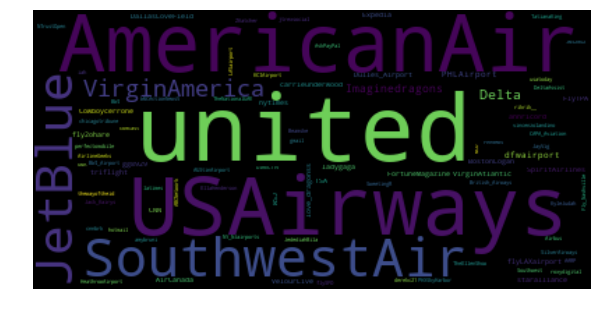

In [26]:
from wordcloud import WordCloud
at_cloud = WordCloud(collocations=False).generate(all_mentions_str)
plt.figure(figsize=(10,10) )
plt.imshow(at_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [159]:
at_and_text_tokenizer = RegexpTokenizer("[\w+'-]+")
removed_links = tweets.text.str.replace(r'http\S+', 'link')
at_and_texted = removed_links.map(lambda t: at_and_text_tokenizer.tokenize(t))
all_tweet_str = ' '.join([' '.join(at_and_texted.values[i]) for i in range(at_and_texted.shape[0])])
all_tweet_str = re.sub(r"@", "", all_tweet_str)

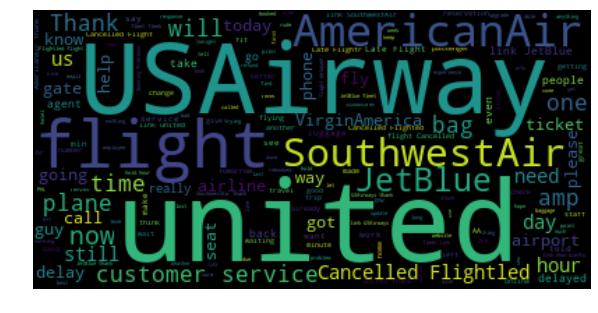

In [161]:
text_cloud = WordCloud().generate(all_tweet_str)
plt.figure(figsize=(10,10) )
plt.imshow(text_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [162]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

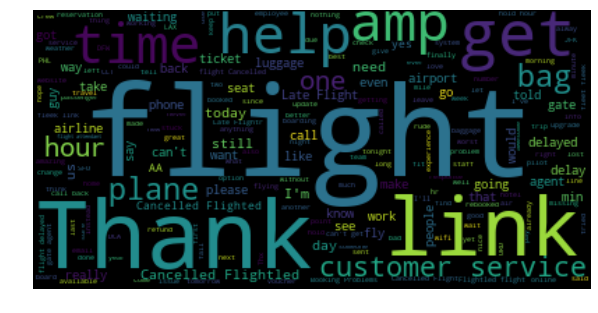

In [163]:
text_cloud = WordCloud(stopwords=stopwords).generate(all_tweet_str)
plt.figure(figsize=(10,10) )
plt.imshow(text_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

While looking at items in `text_cloud.words_`, I noticed that there were some things that needed to be cleaned, for example the phrase "Late Flightr" shows up reasonably often... 

In [172]:
text_cloud.words_['Late Flightr']

0.06914660831509847

In [174]:
text_cloud.words_['Late Flight']

0.10897155361050329

In [175]:
print(tweets.text.where(tweets.text.str.contains('Late Flightr')).dropna()[539])

@united See? We were told repeatedly that the pilot was Late Flight and kept getting Late Flightr.  After we boarded, there was a defibrillator issue.


It turns out that the text of this tweet has been post-processed: the text of the original tweet is: 
> @united See? We were told repeatedly that the pilot was late and kept getting later. After we boarded, there was a defibrillator issue.

It looks like "late" may sometimes be replaced with "Late Flight". This probably occurred during post-processing/ sentiment analysis. We notice that the`negativereason` field is filled out for this entry.

In [170]:
tweets.iloc[539]

tweet_id                                                       570289777184002048
airline_sentiment                                                        negative
airline_sentiment_confidence                                                    1
negativereason                                                        Late Flight
negativereason_confidence                                                  0.6624
airline                                                                    United
airline_sentiment_gold                                                        NaN
name                                                                BocheBillions
negativereason_gold                                                           NaN
retweet_count                                                                   0
text                            @united See? We were told repeatedly that the ...
tweet_coord                                                                   NaN
tweet_created   

"Cancelled Flightled" is another funny phrase that shows up. 

In [190]:
tweets.iloc[129].text

'@VirginAmerica is flight 882 Cancelled Flightled and what do I do if it is?'

The original tweet reads 
> @VirginAmerica is flight 882 cancelled and what do I do if it is?

In [192]:
tweets.iloc[129].negativereason

nan

In this case the sentiment of the tweet was deemed neutral and so there's no negative reason. So probably all text is postprocessed, not just when the sentiment was detected to be negative. 

## Basic sentiment analysis with scikit-learn 

Let's process the data slightly differently: replace links with "link", remove emojis, remove @s but not handles, remove #s but not the tags themselves take out stopwords. 

In [206]:
S = tweets.text.str.replace(r'http\S+', 'link') #replace links 
unicode_emoji_ranges= ['[\U0001f300-\U0001f5fF]',
                        '[\U0001f600-\U0001f64F]',
                        '[\U0001f680-\U0001f6FF]',
                        '[\U00002600-\U000026FF]',
                        '[\U00002700-\U000027BF]']
for emojis in unicode_emoji_ranges: 
    S = S.str.replace(emojis, '')
S = S.str.replace(r"@", "")
S = S.str.replace(r"#", "")
S = S.map(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [208]:
S.head()

0                                  What dhepburn said.
1          plus added commercials experience... tacky.
2       I today... Must mean I need take another trip!
3    really aggressive blast obnoxious "entertainme...
4                                 really big bad thing
Name: text, dtype: object

We can use the sentiment analysis performed by Crowdflower to transform this into a supervised learning problem, at least for now.

Note that the sentiment they record is the airline_sentiment. 

In [210]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [229]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
labels = enc.fit_transform(tweets.airline_sentiment).reshape(-1,1)
count_vect = CountVectorizer()
tweets_vect = count_vect.fit_transform(S.values)
X_train, X_test, y_train, y_test = train_test_split(tweets_vect, labels, test_size = .25)

In [230]:
from sklearn.naive_bayes import MultinomialNB

sentiment_classifier = MultinomialNB().fit(X_train, y_train)

/conda/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [228]:
y_pred = sentiment_classifier.predict(y_test)
sklearn.metrics.accuracy_score(y_test, y_pred)

ValueError: Expected 2D array, got 1D array instead:
array=[0 2 2 ... 2 0 2].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.